# Porto Seguro's Safe Driver Prediction
[참고1] https://www.kaggle.com/bertcarremans/data-preparation-exploration#Introduction   <br>
[참고2] https://colab.research.google.com/drive/1b-L1YNurN884mrbzZLDkE3JP-pwbt_5J#scrollTo=7Kno_9U_TIu6

### data info
* 유사한 feature들은 같은 태그를 가직고 있음 (ind, reg, car, calc,,,)
* bin이 붙어있는 컬럼은 binary features 이고, cat이 붙어있는 컬럼은 categorical features를 의미.
* 둘다 없는 features는 continuous 또는 ordinal 데이터
* -1 값은 missing data (nan 값이 -1로 처리되어있음)
* target컬럼은 보험계약자로부터의 청구 여부.

--------------------------------------------------------------------------------------------------------------------------------------------
### What I learned
* groupby 한 다음 새로 집계한 컬럼명 설정
    * pd.DataFrame( { 'name':meta.groupby([]).size() } )
    * groupby에서 size()와 count()차이 : count()는 NaN값은 카운팅하지 않고 size()는 NaN값도 카운팅 함.
* 자료의 종류
    * nominal data (명목 자료)
    * ordinal data (순서 자료)
    * interval data (구간 자료)
    * ratio data (비율 자료)
    * discrete vs continuous (이산형, 연속형)
* 함수로 plot 한번에 그리기
* 교호작용 (interaction variable)
    * PolynomialFeatures 사용
    * poly.get_feature_names() 으로 새로운 변수에 열 이름 할당
    

### EDA process
* 메타데이터 생성 : 데이터 탐색을 용이하게 하기위해 메타정보를 데이터프레임에 저장.
    * 범주형 데이터인지, 수치형인지 등
* 각 메타데이터 종류별 기술통계 확인
* 불균형클래스 다루기 : 종속변수 0,1 중 0인 데이터가 압도적으로 많을 경우 under sampling 필요
* 누락데이터 수치 및 비율 확인
    * 누락 데이터의 비율이 적을경우 제거, 혹은 평균값으로 대치
* 범주형 변수 다루기
    * 더미변수 생성, 교호작용 변수 생성
* 수치형 변수 다루기
    * 변수 간 상관관계 확인
* Feature 선택
    * 분산이 작은 변수 선택방법, random forest 방법


In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', 100)

In [221]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [222]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [223]:
train.tail()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
595207,1488013,0,3,1,10,0,0,0,0,0,1,0,0,0,0,0,13,1,0,0,0.5,0.3,0.692820,10,1,-1,0,1,1,1,1,0,1,31,3,0.374166,0.684631,0.385487,2.645751,0.4,0.5,0.3,3,0,9,0,9,1,12,4,1,9,6,0,1,1,0,1,1
595208,1488016,0,5,1,3,0,0,0,0,0,1,0,0,0,0,0,6,1,0,0,0.9,0.7,1.382027,9,1,-1,0,-1,15,0,0,2,1,63,2,0.387298,0.972145,-1.000000,3.605551,0.2,0.2,0.0,2,4,8,6,8,2,12,4,1,3,8,1,0,1,0,1,1
595209,1488017,0,1,1,10,0,0,1,0,0,0,0,0,0,0,0,12,1,0,0,0.9,0.2,0.659071,7,1,-1,0,-1,1,1,1,2,1,31,3,0.397492,0.596373,0.398748,1.732051,0.4,0.0,0.3,3,2,7,4,8,0,10,3,2,2,6,0,0,1,0,0,0
595210,1488021,0,5,2,3,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.9,0.4,0.698212,11,1,-1,0,-1,11,1,1,2,1,101,3,0.374166,0.764434,0.384968,3.162278,0.0,0.7,0.0,4,0,9,4,9,2,11,4,1,4,2,0,1,1,1,0,0
595211,1488027,0,0,1,8,0,0,1,0,0,0,0,0,0,0,0,7,1,0,0,0.1,0.2,-1.000000,7,0,-1,0,-1,0,1,0,2,1,34,2,0.400000,0.932649,0.378021,3.741657,0.4,0.0,0.5,2,3,10,4,10,2,5,4,4,3,8,0,1,0,0,0,0


알수있는 내용
* 이진 변수
* 범주 값이 정수인 범주형 변수
* 정수 또는 실수 변수
* 값이 -1인 누락된 변수
* 타겟 변수와 ID 변수

In [224]:
train.shape

(595212, 59)

In [225]:
test.shape

(892816, 58)

=> test 데이터가 train데이터보다 많은것을 확인

In [226]:
# 학습할 데이터에 중복 행이 있는지 확인
train.drop_duplicates()
train.shape

(595212, 59)

In [227]:
# 데이터 유형 확인 : 정수인지 실수인지 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     595212 non-null int64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595212 non-null int64
ps_ind_05_cat     595212 non-null int64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64
ps_re

----------------------------------------------------------------------------------------------------------------------------------------------------------------
## Meta data
데이터 관리를 쉽게 하기 위해 변수에 대한 메타 정보를 데이터프레임에 저장합니다. <br>
이렇게 하면 분석, 시각화, 모델링을 위해 특정 변수를 선택하고자 할 때 도움이 될 것입니다. <br>

* role: input, ID, target
* level: nominal, interval, ordinal, binary
* keep: True or False
* dtype: int, float, str

In [228]:
# data라는 변수안에 메타 데이터 담기
data =[]
for f in train.columns:
    # role 정의
    if f =='target':
        role = 'target'
    elif f =='id':
        role = 'id'
    else:
        role='input'
    
    # level 정의
    if 'bin' in f or f =='target':
        level = 'binary'     # binary data : 1,0 과 같이 두개중 하나
    elif 'cat' in f or f =='id':
        level = 'nominal'     # nominal data : 명목자료
    elif train[f].dtype == int:
        level = 'ordinal'     # ordinal data : 순서자료
    elif train[f].dtype == float:
        level = 'interval'    # interval data : 구간자료
    
    # id를 제외한 모든 변수를 True로 초기화
    keep = True
    if f =='id':
        keep = False
    
    # 데이터 유형 정의
    dtype = train[f].dtype
    
    # 변수에 대한 메타 데이터를 담는 사전 만들기
    f_dict= {
        'varname': f,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    data.append(f_dict)
    
# 데이터프레임으로 만들기
meta = pd.DataFrame(data, columns=['varname','role','level','keep','dtype'])
meta.set_index('varname', inplace=True)

In [229]:
meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


In [230]:
# 드롭되지 않은 모든 nominal 변수를 추출하는 예제입니다.
meta[(meta.level == 'nominal') & (meta.keep)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

In [231]:
# role 및 level 당 변수의 개수를 출력합니다
pd.DataFrame({'count': meta.groupby(['role','level'])['role'].size()}).reset_index()

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


----------------------------------------------------------------------------------------------------------------------------------------------------------------
## 기술 통계(Descriptive statistics)
데이터 프레임에 describe 메소드를 적용 할 수도 있습니다. <br>
그러나 범주형 변수와 id 변수에서 평균, 표준 등을 계산하는 것은별로 의미가 없습니다.<br>
범주형 변수는 나중에 시각적으로 살펴볼 것입니다.<br>

### interval 변수

In [232]:
v = meta[(meta.level =='interval')&(meta.keep)].index
train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


### reg 변수
* ps_reg_03 변수만 누락 값이 존재
* 변수들 마다 범위(최소-최대)는 다릅니다. 스케일링을 할 수 있지만 우리가 사용하려는 분류기마다 다를 것 입니다.

### car 변수
* ps_car_12 와 ps_car_14는 누락 값이 존재
* 변수들 마다 범위가 다르고 스케일링 할 수 있다.

### calac 변수
* 누락값이 없다
* 최대가 0.9인 어떤 비율일 것이다.
* 3개의 calc 변수는 모두 유사한 분포를 가지고 있다.

### Ordinal 변수

In [233]:
v = meta[(meta.level =='ordinal')& (meta.keep)].index
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


* ps_car_11만 유일하게 누락값이 존재
* 다양한 범위를 다루기 위해 스케일링을 적용 할 수 있습니다

### Binary 변수

In [234]:
v = meta[(meta.level =='binary')& (meta.keep)].index
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


* train 데이터의 선험은 3.645 %로 매우 불균형합니다.(A priori in the train data is 3.645%, which is strongly imbalanced.)
* 평균을 통해 우리는 대부분의 경우 값이 0이라고 말할 수 있습니다.

## 불균형 클래스 다루기 (Handling imbalanced classes)
target = 1 인 레코드의 비율은 target = 0보다 훨씬 적습니다. <br>
이것은 정확도가 높지만 실제로 부가 가치가있는 모델인지는 모릅니다. 이 문제를 해결할 수있는 두 가지 전략은 다음과 같습니다. <br>
* target=1 레코드를 오버샘플링
* target=0 레코드를 언더샘플링

우리는 오히려 커다란 훈련 세트가 있으므로 언더 샘플링을 할 수 있습니다.

In [235]:
desired_apriori = 0.10

# target값에 따라 인덱스를 가져옴
idx_0 = train[train.target==0].index     # target=0 인 인덱스
idx_1 = train[train.target==1].index     # traget=1 인 인덱스

# target값에 따라 레코드의 원래 번호를 가져옴.
nb_0 = len(train.loc[idx_0])     # target=0인 행의 개수
nb_1 = len(train.loc[idx_1])      # target=1인 행의 개수

# 언더샘플링 비율과 target이 0인 레코드 수를 계산.
undersampling_rate = ((1-desired_apriori)*nb_1) / (nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

# 위에서 구한 언더샘플링 개수만큼 무작위로 선택
undersampled_idx = shuffle(idx_0, random_state = 37, n_samples=undersampled_nb_0)

# target이 1인 인덱스와 언더샘플된 인덱스를 합쳐 구성.
idx_list = list(undersampled_idx) + list(idx_1)

# 언더샘플링 데이터프레임을 반환.
train = train.loc[idx_list].reset_index(drop=True)


Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undersampling: 195246


In [236]:
print(train.shape)
train['target'].value_counts()

(216940, 59)


0    195246
1     21694
Name: target, dtype: int64

## 데이터 품질 검사
### 누락된 값 검사
* 누락은 -1로 표시

In [237]:
vars_with_missing =[]

for f in train.columns:
    # train데이터에서 어떤 컬럼의 값이 -1인 데이터의 개수
    missings = train[train[f]== -1][f].count()
    if missings > 0 :
        # 누락 데이터가 1개라도 있으면 vars_with_missing변수에 append
        vars_with_missing.append(f)
        # 전체 대비 누락 데이터 개수의 비율
        missing_perc = missings / train.shape[0]
        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))
        print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 103 records (7.25%) with missing values
In total, there are 1 variables with missing values
Variable ps_ind_04_cat has 51 records (7.25%) with missing values
In total, there are 2 variables with missing values
Variable ps_ind_05_cat has 2256 records (7.25%) with missing values
In total, there are 3 variables with missing values
Variable ps_reg_03 has 38580 records (7.25%) with missing values
In total, there are 4 variables with missing values
Variable ps_car_01_cat has 62 records (7.25%) with missing values
In total, there are 5 variables with missing values
Variable ps_car_02_cat has 2 records (7.25%) with missing values
In total, there are 6 variables with missing values
Variable ps_car_03_cat has 148367 records (7.25%) with missing values
In total, there are 7 variables with missing values
Variable ps_car_05_cat has 96026 records (7.25%) with missing values
In total, there are 8 variables with missing values
Variable ps_car_07_cat has 4431 records (7.25%) 

* ps_car_03_cat, ps_car_05_cat: 누락 값의 비율이 너무 높습니다. 제거하세요.
* 누락 된 값이있는 다른 범주형 변수의 경우 누락 값 -1을 그대로 둘 수 있습니다.
* ps_reg_03 (continuous): 모든 레코드의 18 %에 대해 값이 누락되었습니다. 평균값으로 바꾸십시오.
* ps_car_11 (ordinal): 누락 된 값이있는 레코드가 5 개뿐입니다. 모드로 교체하십시오.
* ps_car_12 (continuous) : 누락 된 값이있는 레코드가 1 개뿐입니다. 평균값으로 교체하십시오.
* ps_car_14 (continuous) : 모든 레코드의 7 %에 대해 값이 누락되었습니다. 평균값으로 바꾸십시오.

In [238]:
# 누락 된 값이 너무 많은 변수는 제거
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
train.drop(vars_to_drop, inplace=True, axis=1)
meta.loc[(vars_to_drop),'keep'] = False  # 메타 데이터 갱신

# 평균 또는 모드로 대체하기
mean_imp = Imputer(missing_values=-1, strategy='mean', axis=0)
mode_imp = Imputer(missing_values=-1, strategy='most_frequent', axis=0)
train['ps_reg_03'] = mean_imp.fit_transform(train[['ps_reg_03']]).ravel()
train['ps_car_12'] = mean_imp.fit_transform(train[['ps_car_12']]).ravel()
train['ps_car_14'] = mean_imp.fit_transform(train[['ps_car_14']]).ravel()
train['ps_car_11'] = mode_imp.fit_transform(train[['ps_car_11']]).ravel()

/data2/home/suhyuncho/.conda/envs/suhyun2/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/data2/home/suhyuncho/.conda/envs/suhyun2/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


### 범주형 변수의 카디널리티 확인하기
카디널리티는 변수의 존재하는 다른 값들의 수를 의미합니다. <br>
나중에 범주형 변수에서 더미 변수를 만들므로 많은 다른 값을 갖는 변수가 있는지 확인해야합니다.<br>
우리는 이것을 더미 변수로 취급하는 것과 다르게 처리해야합니다.<br>

In [239]:
v = meta[(meta.level=='nominal') & (meta.keep)].index

for f in v : 
    # 명목형 종류의 개수 (ex. 0,1,2 이면 3개)
    dist_values = train[f].value_counts().shape[0]
    print('Variable {} has {} distinct values'. format(f, dist_values))

Variable ps_ind_02_cat has 5 distinct values
Variable ps_ind_04_cat has 3 distinct values
Variable ps_ind_05_cat has 8 distinct values
Variable ps_car_01_cat has 13 distinct values
Variable ps_car_02_cat has 3 distinct values
Variable ps_car_04_cat has 10 distinct values
Variable ps_car_06_cat has 18 distinct values
Variable ps_car_07_cat has 3 distinct values
Variable ps_car_08_cat has 2 distinct values
Variable ps_car_09_cat has 6 distinct values
Variable ps_car_10_cat has 3 distinct values
Variable ps_car_11_cat has 104 distinct values


----------> ps_car_11_cat만 많은 다른 값을 가지고 있습니다.

### EDIT
nickycan은 내 첫 번째 솔루션이 데이터 누설이 있을 수 있다라는 훌륭한 지적을 해주었고,
같은 내용을 다루는 oliver가 만든 커널을 나에게 알려주었다.
그로므로 나는 이 부분을 oliver의 커널로 대체하였다. 모든 크레딧(공?)은 그의 것이다.
이것은 캐글 대회에 참여함으로써 당신이 배울 수 있는 훌륭한 것이다.

nickycan 캐글 프로필: https://www.kaggle.com/nickycan
oliver 캐글 프로필: https://www.kaggle.com/ogrellier

In [255]:
# # Script by https://www.kaggle.com/ogrellier
# # Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
# def add_noise(series, noise_level):
#     return series * (1 + noise_level * np.random.randn(len(series)))

# def target_encode(trn_series=None, 
#                   tst_series=None, 
#                   target=None, 
#                   min_samples_leaf=1, 
#                   smoothing=1,
#                   noise_level=0):
#     """
#     Smoothing은 Daniele Micci-Barreca의 논문에서와 같이 계산됩니다.
#     https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
#     trn_series : pd.Series 형태의 학습할 범주형 피처
#     tst_series : pd.Series 형태의 테스트할 범주형 피처
#     target : pd.Series 형태의 타겟 데이터
#     min_samples_leaf (int) : 범주의 평균을 고려할 최소 샘플
#     smoothing (int) : 범주 평균과 이전의 균형을 맞추기 위한 스무딩 효과 
#     """ 
#     assert len(trn_series) == len(target)
#     assert trn_series.name == tst_series.name
#     temp = pd.concat([trn_series, target], axis=1)
#     # 타겟 평균을 계산
#     averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
#     # 스무딩 계산
#     smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
#     # 모든 타겟 데이터에 평균 적용하기
#     prior = target.mean()
#     # 카운트가 클수록 full_avg가 적어집니다.
#     averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
#     averages.drop(["mean", "count"], axis=1, inplace=True)
#     # 학습, 테스트 데이터에 평균 적용
#     ft_trn_series = pd.merge(
#         trn_series.to_frame(trn_series.name),
#         averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
#         on=trn_series.name,
#         how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
#     # pd.merge는 인덱스를 유지하지 않으므로 복원합니다.
#     ft_trn_series.index = trn_series.index 
#     ft_tst_series = pd.merge(
#         tst_series.to_frame(tst_series.name),
#         averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
#         on=tst_series.name,
#         how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
#     # pd.merge는 인덱스를 유지하지 않으므로 복원합니다.
#     ft_tst_series.index = tst_series.index
#     return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [256]:
# train_encoded, test_encoded = target_encode(train["ps_car_11_cat"], 
#                              test["ps_car_11_cat"], 
#                              target=train.target, 
#                              min_samples_leaf=100,
#                              smoothing=10,
#                              noise_level=0.01)
    
# train['ps_car_11_cat_te'] = train_encoded
# train.drop('ps_car_11_cat', axis=1, inplace=True)
# meta.loc['ps_car_11_cat','keep'] = False  # Updating the meta
# test['ps_car_11_cat_te'] = test_encoded
# test.drop('ps_car_11_cat', axis=1, inplace=True)

--------------------------------------------------
## 탐색 데이터 시각화
### 범주형 변수

In [240]:
meta[(meta.level=='nominal') & (meta.keep)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_04_cat', 'ps_car_06_cat', 'ps_car_07_cat',
       'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

In [241]:
train[['ps_ind_02_cat', 'target']].groupby(['ps_ind_02_cat'], as_index=False).mean().sort_values(by='target', ascending=False)

,ps_ind_02_cat,target
0,-1,0.388350
4,4,0.112349
2,2,0.104102
3,3,0.101746
1,1,0.098190


<Figure size 432x288 with 0 Axes>

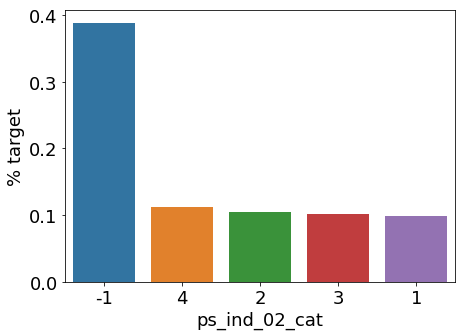

<Figure size 432x288 with 0 Axes>

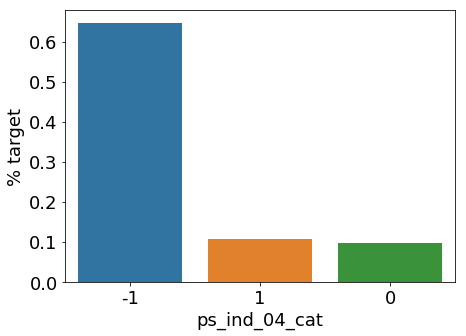

<Figure size 432x288 with 0 Axes>

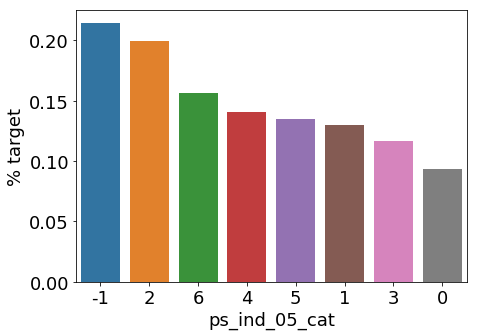

<Figure size 432x288 with 0 Axes>

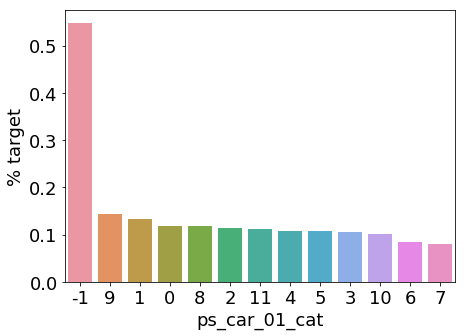

<Figure size 432x288 with 0 Axes>

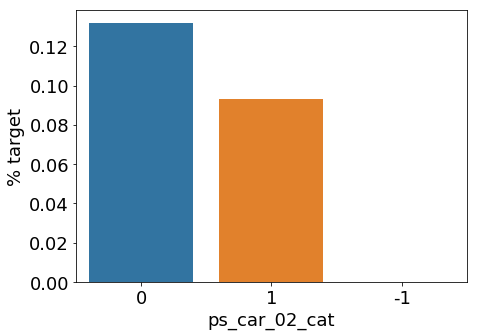

<Figure size 432x288 with 0 Axes>

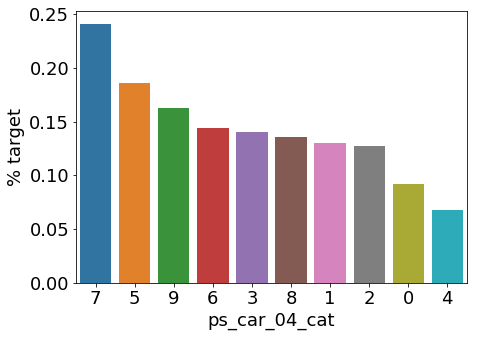

<Figure size 432x288 with 0 Axes>

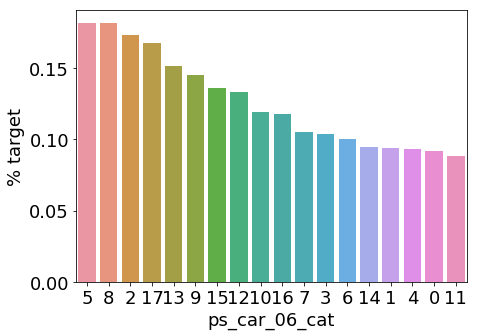

<Figure size 432x288 with 0 Axes>

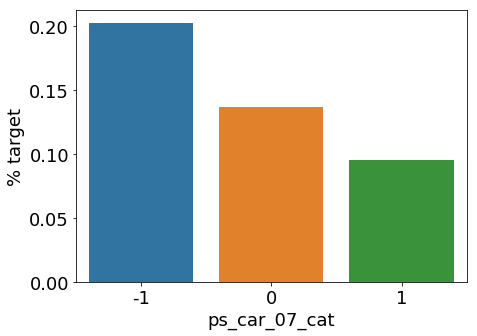

<Figure size 432x288 with 0 Axes>

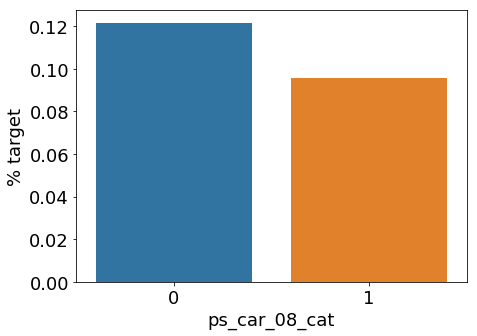

<Figure size 432x288 with 0 Axes>

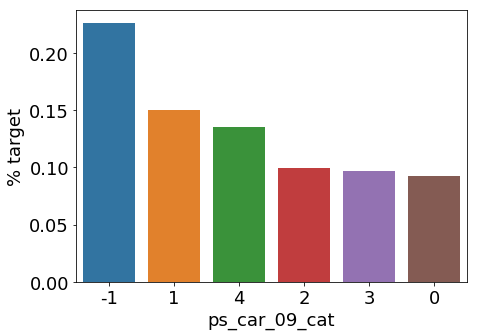

<Figure size 432x288 with 0 Axes>

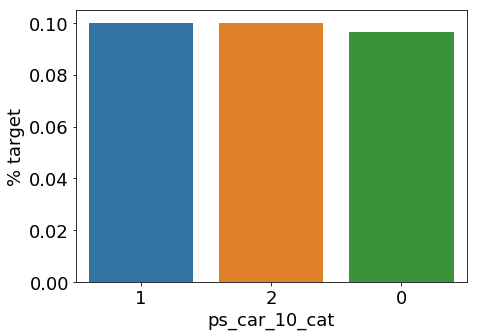

<Figure size 432x288 with 0 Axes>

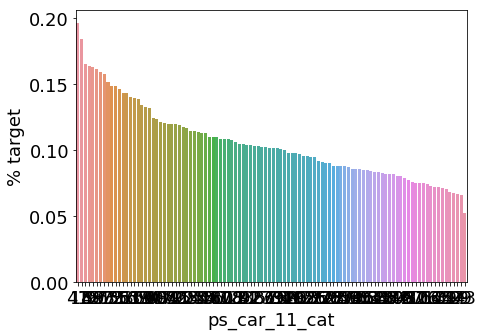

In [242]:
# 범주형 이면서 keep=True인 변수명
v = meta[(meta.level=='nominal') & (meta.keep)].index

for f in v:
    plt.figure()
    fig, ax = plt.subplots(figsize=(7,5))
    
    # 범주형 값 당 타겟값이 1인 퍼센트를 계산
    cat_perc = train[[f, 'target']].groupby([f], as_index=False).mean()
    # 퍼센트 값 큰 순으로 나열
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    
    # Bar-plot
    sns.barplot(ax=ax, x=f, y='target', data=cat_perc, order=cat_perc[f] )
    plt.ylabel('% target', fontsize=18)
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.show();

누락된 값이 있는 변수에서 알 수 있듯, 모드를 사용하는 것 대신 누락된 값을 별도의 범주 값으로 유지하는 것은 좋은 생각이다. <br>
누락된 값을 나타내는 고객들은 보험금 청구를 요구할 확률이 훨씬 더 높은 것으로 보인다.

### Interval 변수
Interval 변수 사이의 상관 관계를 확인해봅니다. <br>
히트맵은 변수간의 상관 관계를 시각화하는 좋은 방법입니다.<br>
아래 코드는 Michael Waskom의 예제를 기반으로합니다.<br>


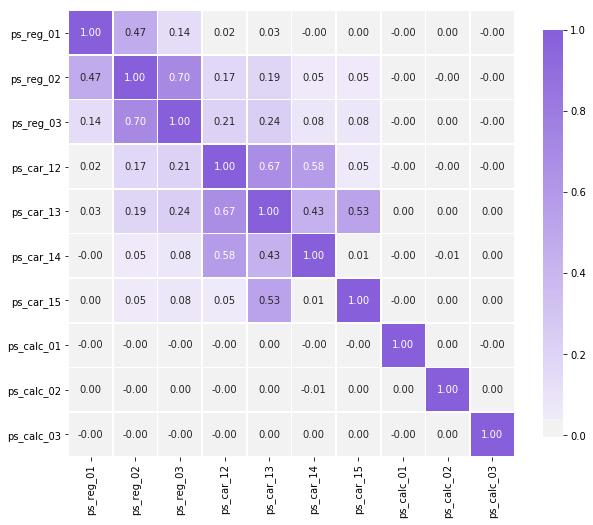

In [243]:
def corr_heatmap(v):
    correlations = train[v].corr()

    # 두 가지 색상 사이의 색상 맵 만들기
    cmap = sns.diverging_palette(150, 275, as_cmap=True)

    fig, ax = plt.subplots(figsize=(10,10))
    # cbar_kws : 오른쪽 막대 위치, vmax와 center값으로 가운데만 음영 들어가도록 설정
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show();
    
v = meta[(meta.level == 'interval') & (meta.keep)].index
corr_heatmap(v)

다음 변수 사이에는 강한 상관 관계가 존재합니다.
* ps_reg_02 and ps_reg_03 (0.70)
* ps_car_12 and ps_car13 (0.67)
* ps_car_12 and ps_car14 (0.58)
* ps_car_13 and ps_car15 (0.67)

seaborn은 변수 사이의 (선형) 관계를 시각화하는 몇 가지 편리한 플롯을 가지고 있습니다. <br>
변수 사이의 관계를 시각화하기 위해 pair플롯을 사용할 수 있습니다.<br>
히트 맵은 이미 제한된 수의 상관 관계 변수를 보여주기 때문에 각 상관 관계가 높은 변수를 개별적으로 살펴볼 것입니다.<br>

In [244]:
s = train.sample(frac=0.1)
s.shape

(21694, 57)

회귀선이 보여 주듯이이 변수들 사이에는 선형 관계가 있습니다. <br>
hue 변수 덕분에 target = 0 및 target = 1에 대한 회귀선이 동일하다는 것을 알 수 있습니다.

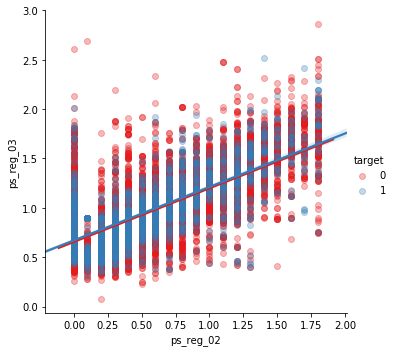

In [245]:
sns.lmplot(x='ps_reg_02', y='ps_reg_03', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

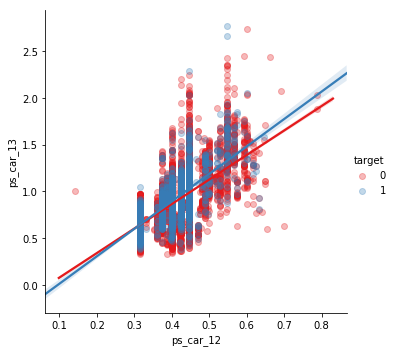

In [246]:
sns.lmplot(x='ps_car_12', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

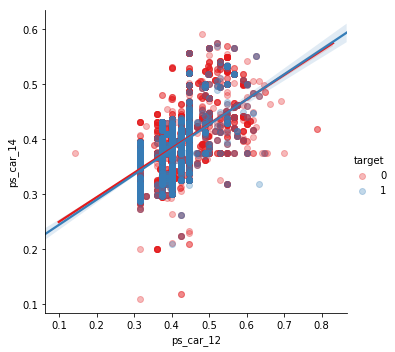

In [247]:
sns.lmplot(x='ps_car_12', y='ps_car_14', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

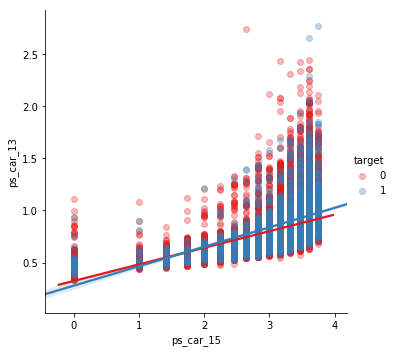

In [248]:
sns.lmplot(x='ps_car_15', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

어떤 상관 관계가 있는 변수를 유지할 것인지 어떻게 정해야 할까? <br>
변수에 대한 주성분 분석(PCA)을 수행하여 차원을 줄일 수 있다.<br>
그러나 상관 관계 변수의 수가 다소 적기 때문에, 우리는 모델이 무거워지게 할 것입니다.<br>

참고할 PCA 커널: https://www.kaggle.com/bertcarremans/reducing-number-of-numerical-features-with-pca

### ordinal 변수 간의 상관 관계 확인 

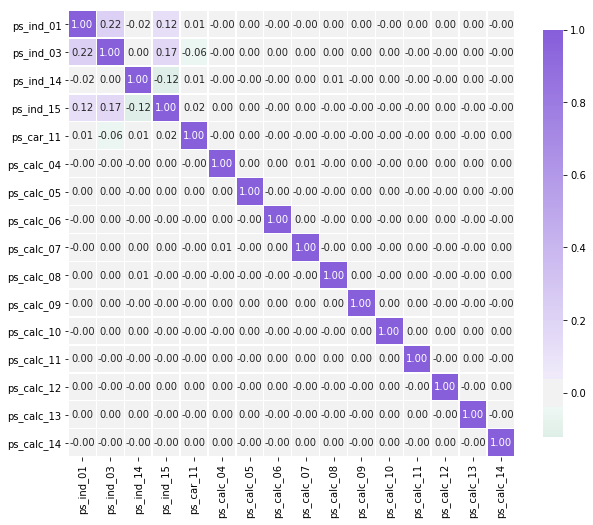

In [249]:
v = meta[(meta.level=='ordinal')&(meta.keep)].index
corr_heatmap(v)

ordinal 변수에 대해서는 많은 상관 관계를 볼 수 없습니다. <br>
반면에 타겟 값을 기준으로 그룹화 할 때 분포가 어떻게되는지 살펴볼 수 있습니다.

--------------------------------------
## feature engineering
### 더미변수 만들기
범주형 변수의 값은 순서 또는 크기를 나타내지 않는다. <br>
예를 들어 카테고리 2는 카테고리 1의 값의 2배가 아니다.<br>
그러므로 우리는 카테고리 값을 다루기 위해 더미 변수를 만들 수 있습니다. <br>
첫 번째 더미 변수는 원래 변수의 범주에 대해 생성 된 다른 더미 변수에서 파생 될 수 있기 때문에 버립니다.<br>

In [250]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index
print('Before dummification we have {} variables in train'.format(train.shape[1]))
train = pd.get_dummies(train, columns=v, drop_first=True)
print('After dummification we have {} variables in train'.format(train.shape[1]))

Before dummification we have 57 variables in train
After dummification we have 211 variables in train


### interaction변수 만들기(교호작용)

In [257]:
v = meta[(meta.level == 'interval') & (meta.keep)].index
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
interactions = pd.DataFrame(data=poly.fit_transform(train[v]), columns=poly.get_feature_names(v))
interactions.drop(v, axis=1, inplace=True)
# train 데이터에 상호 작용 변수 연결
print('Before creating interactions we have {} variables in train'.format(train.shape[1]))
train = pd.concat([train, interactions], axis=1)
print('After creating interactions we have {} variables in train'.format(train.shape[1]))


Before creating interactions we have 211 variables in train
After creating interactions we have 266 variables in train


train 데이터에 추가적인 상호 작용 변수를 넣어줍니다. <br>
get_feature_names 메소드 덕분에이 새로운 변수에 열 이름을 할당 할 수 있습니다.

In [262]:
train.head()

,id,target,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,ps_ind_02_cat_1,ps_ind_02_cat_2,ps_ind_02_cat_3,ps_ind_02_cat_4,ps_ind_04_cat_0,...,ps_reg_01 ps_car_14,ps_reg_01 ps_car_15,ps_reg_01 ps_calc_01,ps_reg_01 ps_calc_02,ps_reg_01 ps_calc_03,ps_reg_02^2,ps_reg_02 ps_reg_03,ps_reg_02 ps_car_12,ps_reg_02 ps_car_13,ps_reg_02 ps_car_14,ps_reg_02 ps_car_15,ps_reg_02 ps_calc_01,ps_reg_02 ps_calc_02,ps_reg_02 ps_calc_03,ps_reg_03^2,ps_reg_03 ps_car_12,ps_reg_03 ps_car_13,ps_reg_03 ps_car_14,ps_reg_03 ps_car_15,ps_reg_03 ps_calc_01,ps_reg_03 ps_calc_02,ps_reg_03 ps_calc_03,ps_car_12^2,ps_car_12 ps_car_13,ps_car_12 ps_car_14,ps_car_12 ps_car_15,ps_car_12 ps_calc_01,ps_car_12 ps_calc_02,ps_car_12 ps_calc_03,ps_car_13^2,ps_car_13 ps_car_14,ps_car_13 ps_car_15,ps_car_13 ps_calc_01,ps_car_13 ps_calc_02,ps_car_13 ps_calc_03,ps_car_14^2,ps_car_14 ps_car_15,ps_car_14 ps_calc_01,ps_car_14 ps_calc_02,ps_car_14 ps_calc_03,ps_car_15^2,ps_car_15 ps_calc_01,ps_car_15 ps_calc_02,ps_car_15 ps_calc_03,ps_calc_01^2,ps_calc_01 ps_calc_02,ps_calc_01 ps_calc_03,ps_calc_02^2,ps_calc_02 ps_calc_03,ps_calc_03^2
0,353762,0,1,1,1,0,0,0,0,0,0,0,0,11,0,1,0,0.6,0.6,0.838153,1.0,0.368782,0.540603,0.345688,2.000000,0.9,0.3,0.0,3,0,7,3,8,4,8,1,0,4,6,0,1,1,0,0,1,1,0,0,0,0,...,0.207413,1.200000,0.54,0.18,0.00,0.36,0.502892,0.221269,0.324362,0.207413,1.200000,0.54,0.18,0.00,0.702500,0.309095,0.453108,0.289739,1.676305,0.754337,0.251446,0.000000,0.136,0.199365,0.127483,0.737564,0.331904,0.110635,0.000000,0.292252,0.186880,1.081207,0.486543,0.162181,0.000000,0.1195,0.691375,0.311119,0.103706,0.000000,4.0,1.800000,0.600000,0.000000,0.81,0.27,0.00,0.09,0.00,0.00
1,845629,0,5,7,1,0,0,0,0,0,0,0,0,5,0,0,1,0.9,0.6,0.728440,1.0,0.424264,0.382953,0.378814,0.000000,0.2,0.0,0.6,1,1,7,5,10,4,11,3,0,3,7,0,0,0,0,1,0,1,0,0,0,0,...,0.340933,0.000000,0.18,0.00,0.54,0.36,0.437064,0.254558,0.229772,0.227288,0.000000,0.12,0.00,0.36,0.530625,0.309051,0.278958,0.275943,0.000000,0.145688,0.000000,0.437064,0.180,0.162473,0.160717,0.000000,0.084853,0.000000,0.254558,0.146653,0.145068,0.000000,0.076591,0.000000,0.229772,0.1435,0.000000,0.075763,0.000000,0.227288,0.0,0.000000,0.000000,0.000000,0.04,0.00,0.12,0.00,0.00,0.36
2,1449185,0,4,3,1,0,0,0,0,0,0,0,0,4,1,0,0,0.9,0.6,0.869267,3.0,0.400000,0.814271,0.402368,3.316625,0.3,0.9,0.1,4,1,8,5,10,2,8,7,2,3,10,0,1,0,1,0,1,1,0,0,0,0,...,0.362131,2.984962,0.27,0.81,0.09,0.36,0.521560,0.240000,0.488563,0.241421,1.989975,0.18,0.54,0.06,0.755625,0.347707,0.707819,0.349765,2.883032,0.260780,0.782340,0.086927,0.160,0.325708,0.160947,1.326650,0.120000,0.360000,0.040000,0.663037,0.327637,2.700631,0.244281,0.732844,0.081427,0.1619,1.334504,0.120710,0.362131,0.040237,11.0,0.994987,2.984962,0.331662,0.09,0.27,0.03,0.81,0.09,0.01
3,834066,0,6,6,1,0,0,0,0,0,0,0,0,8,1,0,0,0.6,1.5,1.705872,2.0,0.400000,0.838387,0.378418,3.605551,0.8,0.4,0.1,3,3,7,2,11,3,10,2,2,0,14,0,0,0,0,0,0,1,0,0,0,1,...,0.227051,2.163331,0.48,0.24,0.06,2.25,2.558808,0.600000,1.257580,0.567627,5.408327,1.20,0.60,0.15,2.910000,0.682349,1.430181,0.645532,6.150610,1.364698,0.682349,0.170587,0.160,0.335355,0.151367,1.442221,0.320000,0.160000,0.040000,0.702893,0.317260,3.022847,0.670710,0.335355,0.083839,0.1432,1.364405,0.302734,0.151367,0.037842,13.0,2.884441,1.442221,0.360555,0.64,0.32,0.08,0.16,0.04,0.01
4,436189,0,5,5,0,0,1,0,0,0,0,0,0,10,1,0,0,0.8,0.8,1.086566,3.0,0.400000,0.905777,0.384838,3.605551,0.6,0.5,0.9,3,3,5,2,9,1,6,5,1,6,8,0,1,1,1,0,1,1,0,0,0,1,...,0.307870,2.884441,0.48,0.40,0.72,0.64,0.869253,0.320000,0.724622,0.307870,2

## Feature 선택
### 분산이 낮거나 0인 피처 제거
개인적으로는 분류 알고리즘이 유지할 피처를 고르는 것을 선호합니다. <br>
그러나 우리가 할 수있는 한가지 일이 있습니다.<br>
그것은 변화가 없거나 매우 적은 피처들을 제거하는 것입니다. <br>
Sklearn은이를위한 편리한 방법을 가지고 있습니다 : VarianceThreshold. <br>
기본적으로 분산이 0인 피처를 제거합니다. <br>
이전 단계에서 분산이 0인 피처가 없다는것을 알았으므로 이 대회에 적용하진 않을 것입니다.<br>


원래 예측모형에서 중요한 특징데이터란 종속데이터와의 상관관계가 크고 예측에 도움이 되는 데이터를 말한다. <br>
하지만 상관관계 계산에 앞서 특징데이터의 값 자체가 표본에 따라 그다지 변하지 않는다면 종속데이터 예측에도 도움이 되지 않을 가능성이 높다. <br>
하지만 분산에 의한 선택은 반드시 상관관계와 일치한다는 보장이 없기 때문에 신중하게 사용해야 한다 .

In [264]:
selector = VarianceThreshold(threshold=.01)
selector.fit(train.drop(['id', 'target'], axis=1)) # id와 target 변수 없이 훈련하는 것이 적합하다.
f = np.vectorize(lambda x : not x) # 부울 배열 요소를 토글하는 함수
v = train.drop(['id', 'target'], axis=1).columns[f(selector.get_support())]
print('{} variables have too low variance.'.format(len(v)))
print('These variables are {}'.format(list(v)))

102 variables have too low variance.
These variables are ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_12', 'ps_car_14', 'ps_ind_05_cat_2', 'ps_ind_05_cat_5', 'ps_car_01_cat_1', 'ps_car_01_cat_2', 'ps_car_04_cat_3', 'ps_car_04_cat_4', 'ps_car_04_cat_5', 'ps_car_04_cat_6', 'ps_car_04_cat_7', 'ps_car_06_cat_2', 'ps_car_06_cat_5', 'ps_car_06_cat_8', 'ps_car_06_cat_12', 'ps_car_06_cat_16', 'ps_car_06_cat_17', 'ps_car_09_cat_4', 'ps_car_10_cat_1', 'ps_car_10_cat_2', 'ps_car_11_cat_2', 'ps_car_11_cat_3', 'ps_car_11_cat_4', 'ps_car_11_cat_6', 'ps_car_11_cat_7', 'ps_car_11_cat_8', 'ps_car_11_cat_9', 'ps_car_11_cat_13', 'ps_car_11_cat_14', 'ps_car_11_cat_15', 'ps_car_11_cat_17', 'ps_car_11_cat_18', 'ps_car_11_cat_19', 'ps_car_11_cat_20', 'ps_car_11_cat_21', 'ps_car_11_cat_23', 'ps_car_11_cat_24', 'ps_car_11_cat_25', 'ps_car_11_cat_26', 'ps_car_11_cat_29', 'ps_car_11_cat_30', 'ps_car_11_cat_31', 'ps_car_11_cat_33', 'ps_car_11_cat_34', 'ps_car_11_cat_35', 'ps_car_11

### Selecting features with a Random Forest and SelectFromModel.
우리는 랜덤 포레스트의 중요한 피처들을 기반으로 피처 선택을 할 것입니다. <br>
Sklearn의 SelectFromModel을 사용하여 지킬 변수 수를 지정할 수 있습니다.<br>
피처 중요도 수준에서 임계 값을 수동으로 설정할 수 있습니다.<br>
하지만 우리는 간단히 상위 50 % 상위 변수만 선택할 것입니다.<br>

In [268]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']

feat_labels = X_train.columns

rf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

rf.fit(X_train, y_train)
importances = rf.feature_importances_

indices = np.argsort(rf.feature_importances_)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,feat_labels[indices[f]], importances[indices[f]]))

 1) ps_car_13                      0.016867
 2) ps_car_13^2                    0.016865
 3) ps_reg_03 ps_car_13            0.016614
 4) ps_car_12 ps_car_13            0.016590
 5) ps_car_13 ps_car_14            0.016559
 6) ps_reg_01 ps_car_13            0.016314
 7) ps_car_13 ps_car_15            0.016221
 8) ps_reg_03 ps_car_14            0.015711
 9) ps_reg_03 ps_car_12            0.015127
10) ps_reg_03 ps_car_15            0.014793
11) ps_car_13 ps_calc_01           0.014403
12) ps_car_13 ps_calc_02           0.014388
13) ps_car_14 ps_car_15            0.014368
14) ps_car_13 ps_calc_03           0.014362
15) ps_reg_02 ps_car_13            0.014297
16) ps_reg_01 ps_reg_03            0.014260
17) ps_reg_03                      0.013993
18) ps_reg_03^2                    0.013962
19) ps_reg_01 ps_car_14            0.013875
20) ps_reg_03 ps_calc_03           0.013505
21) ps_reg_03 ps_calc_02           0.013448
22) ps_reg_03 ps_calc_01           0.013430
23) ps_car_14 ps_calc_02        

SelectFromModel을 사용하여 사용할 사전 분류기와 피처 중요도를 위한 임계값을 명시할 수 있다. <br>
get_support 메소드를 사용하면 train 데이터의 변수 수를 제한 할 수 있습니다.

In [269]:
sfm = SelectFromModel(rf, threshold='median', prefit=True)
print('Number of features before selection: {}'.format(X_train.shape[1]))
n_features = sfm.transform(X_train).shape[1]
print('Number of features after selection: {}'.format(n_features))
selected_vars = list(feat_labels[sfm.get_support()])

Number of features before selection: 264
Number of features after selection: 132


In [270]:
train = train[selected_vars + ['target']]

### 피쳐 스케일링
 Standard 스케일링을 train 데이터에 적용 할 수 있습니다.
몇몇 분류기는 이 작업을 하면 더 좋은 성능을 보입니다.

In [271]:
scaler = StandardScaler()
scaler.fit_transform(train.drop(['target'], axis=1))

/data2/home/suhyuncho/.conda/envs/suhyun2/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/data2/home/suhyuncho/.conda/envs/suhyun2/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[-0.45941104, -1.26665356,  1.25877984, ..., -0.72553616,
        -1.01071913, -1.06173767],
       [ 1.55538958,  0.95034274,  1.25877984, ..., -1.06120876,
        -1.01071913,  0.27907892],
       [ 1.05168943, -0.52765479,  1.25877984, ...,  1.95984463,
        -0.56215309, -1.02449277],
       ...,
       [-0.9631112 ,  0.58084336, -0.7944201 , ..., -0.46445747,
         0.18545696,  0.27907892],
       [-0.9631112 , -0.89715418,  1.25877984, ..., -0.91202093,
        -0.41263108,  0.27907892],
       [-0.45941104, -1.26665356, -0.7944201 , ...,  0.28148164,
        -0.11358706, -0.72653353]])